In [1]:
from pyspark.sql import SparkSession

# Initializing Spark session
from pyspark.sql import SparkSession

spark_session = SparkSession.builder\
        .master("spark://192.168.2.156:7077") \
        .appName("Project_22_Ville_Holma")\
        .config("spark.dynamicAllocation.enabled", False)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.cores.max", 8)\
        .config("spark.executor.cores", 2)\
        .config("spark.executor.instances", 4)\
        .config("spark.executor.memory", "4g")\
        .config("spark.driver.port",9999)\
        .config("spark.blockManager.port",10005)\
        .config("spark.hadoop.fs.defaultFS", "hdfs://192.168.2.156:9000") \
        .getOrCreate()

spark_context = spark_session.sparkContext
spark_context.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/11 15:59:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
reddit_path = "hdfs://192.168.2.156:9000/data/reddit"
# Get file sizes using Hadoop FileSystem API
hadoop_conf = spark_context._jsc.hadoopConfiguration()
fs = spark_context._gateway.jvm.org.apache.hadoop.fs.FileSystem.get(hadoop_conf)
path = spark_context._gateway.jvm.org.apache.hadoop.fs.Path(reddit_path)

# Get total size
total_size = fs.getContentSummary(path).getLength()

# Convert to human-readable format (GB)
size_in_gb = total_size / (1024 ** 3)
print(f"Total dataset size: {size_in_gb:.2f} GB")

Total dataset size: 25.15 GB


Data Loading Time: 190.28 seconds
Number of worker nodes: 4
Filtering Time: 0.08 seconds
Preprocessing Time: 0.56 seconds
Word Frequency Computation Time: 0.25 seconds


[Stage 5:>                                                          (0 + 1) / 1]

Number of partitions: 1


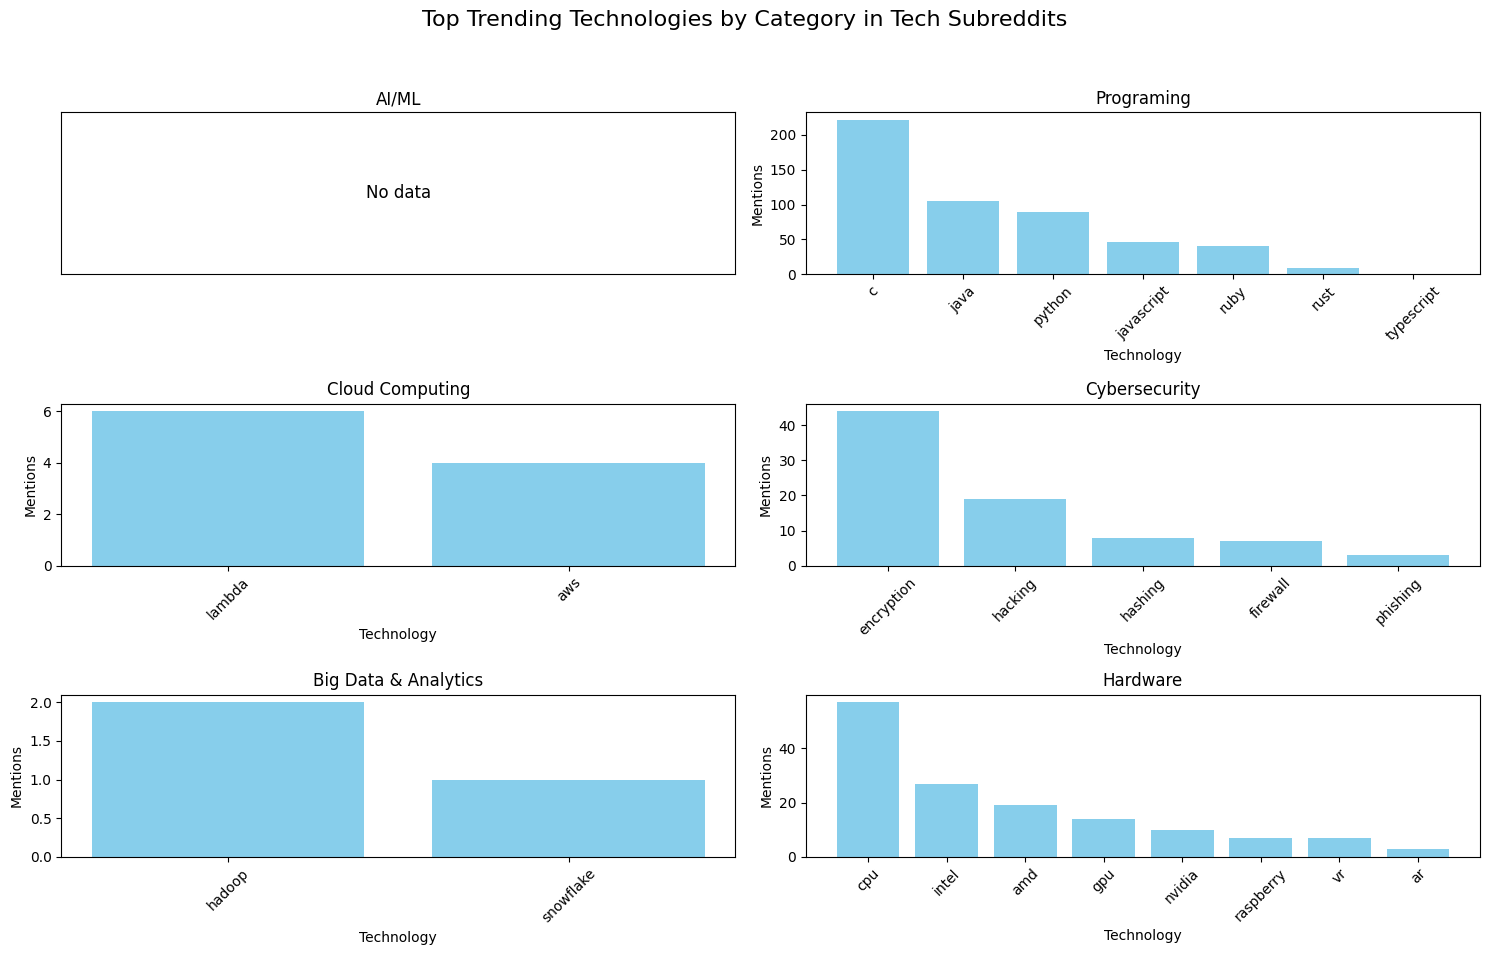

Plotting Time: 3.21 seconds
Total Execution Time: 279.15 seconds
Number of worker nodes: 4
Filtering Time: 0.02 seconds
Preprocessing Time: 0.15 seconds
Word Frequency Computation Time: 0.16 seconds


[Stage 9:=============>                                          (47 + 8) / 196]

In [ ]:
import time
import re
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, StringType

spark_session.catalog.clearCache()

dataset_fractions = [0.1, 0.25, 0.5, 1.0]
execution_times = []

# ===============================
#  Load Data from HDFS
# ===============================
load_start = time.time()
df_original = spark_session.read.json(reddit_path)
load_end = time.time()
print(f"Data Loading Time: {load_end - load_start:.2f} seconds")

for fraction in dataset_fractions:
    # ===============================
    #  1. Initialize start time
    # ===============================
    start_time = time.time()  # Start tracking total execution time

    # ===============================
    #  2 Fraction of the data
    # ===============================    
    df = df_original.sample(fraction=fraction, seed=0)
    num_workers = spark_session.sparkContext._jsc.sc().getExecutorMemoryStatus().size() - 1
    print(f'Number of worker nodes: {num_workers}')
    
    # ===============================
    #  3. Filter for Tech-Related Subreddits
    # ===============================
    filter_start = time.time()
    tech_subreddits = ["technology", "programming", "datascience", "MachineLearning", "AI"]
    df_filtered = df.filter(df.subreddit.isin(tech_subreddits))
    filter_end = time.time()
    print(f"Filtering Time: {filter_end - filter_start:.2f} seconds")
    
    # ===============================
    #  4. Preprocess Text Data (Improved)
    # ===============================
    
    # Function to clean text (lowercase, remove punctuation, numbers)
    def clean_text(text):
        if text:
            text = text.lower()
            text = re.sub(r'[^a-z\s]', '', text)  # Keep only letters
            return text.split()
        return []
    
    # Register UDF for Spark
    clean_text_udf = udf(clean_text, ArrayType(StringType()))
    
    # Apply cleaning
    preprocess_start = time.time()
    df_cleaned = df_filtered.withColumn("cleaned_body", clean_text_udf(col("body")))
    
    # Remove stopwords
    remover = StopWordsRemover(inputCol="cleaned_body", outputCol="filtered_words")
    df_final = remover.transform(df_cleaned)
    preprocess_end = time.time()
    print(f"Preprocessing Time: {preprocess_end - preprocess_start:.2f} seconds")
    
    # ===============================
    #  5. Compute Word Frequencies (Grouped by Technology Category)
    # ===============================
    
    # Explode words into individual rows
    word_count_start = time.time()
    df_words = df_final.withColumn("word", F.explode(F.col("filtered_words")))
    ","
    # **Technology Categories**
    tech_categories = {
        "AI/ML": ["tensorflow", "pytorch", "scikit", "keras", "fastai", "huggingface", "gpt"],
        "Programing": ["python", "java", "javascript", "typescript", "c", "c++", "rust", "golang", "ruby"],
        "Cloud Computing": ["aws", "azure", "gcp", "kubernetes", "docker", "lambda", "serverless"],
        "Cybersecurity": ["cybersecurity", "hacking", "ransomware", "phishing", "encryption", "firewall", "hashing"],
        "Big Data & Analytics": ["hadoop", "spark", "kafka", "snowflake", "databricks", "powerbi", "tableau"],
        "Hardware": ["gpu", "cpu", "nvidia", "amd", "intel", "raspberry", "arduino", "iot", "vr", "ar"]
    }
    
    # **Find words matching any category**
    df_tech_words = df_words.filter(df_words.word.isin(
        [word for category in tech_categories.values() for word in category]
    ))
    
    # **Count occurrences for each word**
    df_word_counts = df_tech_words.groupBy("word").count().orderBy(F.desc("count"))
    word_count_end = time.time()
    print(f"Word Frequency Computation Time: {word_count_end - word_count_start:.2f} seconds")
    print(f'Number of partitions: {df_word_counts.rdd.getNumPartitions()}')
    
    # ===============================
    #  6. Fetch the Top Trending Technologies by Category
    # ===============================
    plot_start = time.time()
    
    # Convert Spark DataFrame to Pandas
    df_pandas = df_word_counts.toPandas()
    
    # Group by category
    category_trends = {category: [] for category in tech_categories}
    
    for category, words in tech_categories.items():
        category_trends[category] = df_pandas[df_pandas["word"].isin(words)].sort_values("count", ascending=False)
    
    # ===============================
    #  7. Plot Top Trending Technologies in Each Category
    # ===============================
    fig, axes = plt.subplots(3, 2, figsize=(15, 10))  # 3 rows, 2 columns
    fig.suptitle("Top Trending Technologies by Category in Tech Subreddits", fontsize=16)
    
    # Flatten axes for easier iteration
    axes = axes.flatten()
    
    for i, (category, df_trend) in enumerate(category_trends.items()):
        if not df_trend.empty:
            axes[i].bar(df_trend["word"], df_trend["count"], color="skyblue")
            axes[i].set_title(category)
            axes[i].set_xlabel("Technology")
            axes[i].set_ylabel("Mentions")
            axes[i].tick_params(axis='x', rotation=45)
        else:
            axes[i].set_title(category)
            axes[i].text(0.5, 0.5, "No data", ha="center", va="center", fontsize=12)
            axes[i].set_xticks([])
            axes[i].set_yticks([])
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    plot_end = time.time()
    print(f"Plotting Time: {plot_end - plot_start:.2f} seconds")
    
    # ===============================
    #  8. Print Total Execution Time
    # ===============================
    total_time = time.time() - start_time
    execution_times.append(total_time)
    print(f"Total Execution Time: {total_time:.2f} seconds")
    

# Plot Execution Time vs. Dataset Size
plt.figure(figsize=(8, 5))
plt.plot(dataset_fractions, execution_times, marker='o', linestyle='-', color='b')
plt.xlabel("Dataset Fraction")
plt.ylabel("Execution Time (seconds)")
plt.title("Scalability Analysis: Execution Time vs. Dataset Size")
plt.grid(True)
plt.show()


In [ ]:
spark_session.stop()